
# Stock Trading using DRL

**DISCLAIMER:** THIS NOTEBOOK IS PROVIDED ONLY AS A REFERENCE SOLUTION NOTEBOOK FOR THE MINI-PROJECT. THERE MAY BE OTHER POSSIBLE APPROACHES/METHODS TO ACHIEVE THE SAME RESULTS.

## Learning Objectives



* perform stock trading using Deep Reinforcement Learning
* build an environment for agent and perform stock trading
* experiment with SAC model and improve the reward
* create a dashboard for stock trading using `jupyter-dash`

## Information

Deep reinforcement learning combines artificial neural networks with a framework of reinforcement learning that helps software agents learn how to reach their goals. That is, it unites function approximation and target optimization, mapping states and actions to the rewards they lead to.

Reinforcement learning refers to goal-oriented algorithms, which learn how to achieve a complex objective (goal) or how to maximize along a particular dimension over many steps; for example, they can maximize the points won in a game over many moves. Reinforcement learning algorithms can start from a blank slate, and under the right conditions, achieve superhuman performance. Like a pet incentivized by scolding and treats, these algorithms are penalized when they make the wrong decisions and rewarded when they make the right ones – this is reinforcement.

![img](https://miro.medium.com/max/974/0*NgZ_bq_nUOq73jK_.png)

**SAC:** Soft Actor Critic is defined for RL tasks involving continuous actions. The biggest feature of SAC is that it uses a modified RL objective function. Instead of only seeking to maximize the lifetime rewards, SAC seeks to also maximize the entropy of the policy. The term ‘entropy’ has a rather esoteric definition and many interpretations depending on the application

![img](https://miro.medium.com/max/353/0*5Y3SzMyOQZBRUhrh.png)

Fig: Actor-Critic architecture. Source: Medium

Learning of the actor is based policy gradient approach and critic is learned in value-based fashion. In SAC, there are three networks: the first network represents state-value(V) parameterised by ψ, the second one is a policy function that parameterised by ϕ, and the last one represents soft q function parameterised by θ.

Read More about SAC [here](https://arxiv.org/abs/1801.01290)

## Dataset

### Dataset Description

The Dataset chosen for this mini project is NIFTY50 Stock tradings. The data is the price history and trading volumes of the fifty stocks in the index NIFTY 50 from NSE (National Stock Exchange) India. All stocks are at a day-level with pricing and trading values split across. The NIFTY 50 is a diversified 50 stock index accounting for 13 sectors of the economy.

See the stock indexes of NIFTY 50 in the following [link](https://www1.nseindia.com/products/content/equities/indices/nifty_50.htm)

**Note:** Choose the NIFTY 50 ticker symbols and download the stock data from '2009-01-01' to '2021-09-01' using YahooDownloader

In [ ]:
#@title Install FinRL, other necessary libraries and extensions
!pip -qq install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

!pip install -q jupyter-dash==0.3.0rc1 dash-bootstrap-components

!pip install pyyaml==5.4.1

!pip install macrodemos --upgrade
!pip install -q dash==2.0.0

  Using cached PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl (636 kB)
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
alpaca-trade-api 2.0.0 requires PyYAML==6.0, but you have pyyaml 5.4.1 which is incompatible.


In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/nifty50list.csv

!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/df_account_value.csv

### Import required packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import warnings
warnings.filterwarnings("ignore")
import datetime
import os
from finrl import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import sys
sys.path.append("../FinRL-Library")

### Data Loading

* Read the ticker symbols of Nifty 50 and add `.NS` extension

* Using the symbols download the stock prices data using YahooDownloader

In [ ]:
# df_account_value = pd.read_csv("df_account_value.csv")

In [ ]:
nif = pd.read_csv("/content/nifty50list.csv")
nif.Symbol = nif.Symbol + ".NS"
nif.Symbol.values

array(['ACC.NS', 'ABBOTINDIA.NS', 'ADANIENT.NS', 'ADANIGREEN.NS',
       'ADANITRANS.NS', 'ALKEM.NS', 'AMBUJACEM.NS', 'APOLLOHOSP.NS',
       'AUROPHARMA.NS', 'DMART.NS', 'BAJAJHLDNG.NS', 'BANDHANBNK.NS',
       'BERGEPAINT.NS', 'BIOCON.NS', 'BOSCHLTD.NS', 'CADILAHC.NS',
       'COLPAL.NS', 'DLF.NS', 'DABUR.NS', 'GAIL.NS', 'GLAND.NS',
       'GODREJCP.NS', 'HDFCAMC.NS', 'HAVELLS.NS', 'HINDPETRO.NS',
       'ICICIGI.NS', 'ICICIPRULI.NS', 'IGL.NS', 'INDUSTOWER.NS',
       'NAUKRI.NS', 'INDIGO.NS', 'JUBLFOOD.NS', 'LTI.NS', 'LUPIN.NS',
       'MRF.NS', 'MARICO.NS', 'MUTHOOTFIN.NS', 'NMDC.NS', 'PETRONET.NS',
       'PIDILITIND.NS', 'PEL.NS', 'PGHH.NS', 'PNB.NS', 'SBICARD.NS',
       'SIEMENS.NS', 'TORNTPHARM.NS', 'UBL.NS', 'MCDOWELL-N.NS',
       'VEDL.NS', 'YESBANK.NS'], dtype=object)

In [ ]:
# Download and save the data in a pandas DataFrame:
df = YahooDownloader(start_date = '2009-01-01',
                          end_date = '2021-09-01',
                          ticker_list = nif.Symbol.values).fetch_data()

print(df.sort_values(['date','tic'],ignore_index=True).head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.tic.nunique()

50

In [ ]:
df.date.min(), df.date.max()

('2009-01-02', '2021-08-31')

In [ ]:
df.dtypes

date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
tic        object
day         int64
dtype: object

### Preprocess Data

FinRL uses a `FeatureEngineer` class to preprocess data. Some of the technical indicators used in the analysis of financial markets includes.

1. relative strength index (RSI): it represents the size of recent gains and losses, during a specified time period.
2. moving average convergence divergence (MACD):  it is an indicator to determine price momentum and short term trend.
3. commodity channel index (CCI): its an indicator helps in identifying cyclical trends.
4. directional index (DX): it represents group of directional movements that form trading system

* Configure the technical indicators and apply feature engineering

  Hint: `FeatureEngineer()`

In [ ]:
# Perform Feature Engineering
tech_indicator_list = config.INDICATORS
print(tech_indicator_list)

['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']


In [ ]:
df.shape

(128561, 8)

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)
df.head()

Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2009-01-02,280.100006,280.100006,280.100006,236.199631,0,ABBOTINDIA.NS,4,0.0,236.199631,236.199631,100.0,66.666667,100.0,236.199631,236.199631
3120,2009-01-02,503.899994,503.899994,484.000000,385.829071,515098,ACC.NS,4,0.0,236.199631,236.199631,100.0,66.666667,100.0,385.829071,385.829071
6240,2009-01-02,24.524010,25.206083,23.987547,19.948494,527417,ADANIENT.NS,4,0.0,236.199631,236.199631,100.0,66.666667,100.0,19.948494,19.948494
9360,2009-01-02,71.750000,72.000000,67.849998,51.071278,2316342,AMBUJACEM.NS,4,0.0,236.199631,236.199631,100.0,66.666667,100.0,51.071278,51.071278
12480,2009-01-02,223.500000,244.875000,219.500000,223.279022,117614,APOLLOHOSP.NS,4,0.0,236.199631,236.199631,100.0,66.666667,100.0,223.279022,223.279022


In [ ]:
df.shape

(106080, 16)

### Exploratory Data Analysis

#### Describe the statistics of the data

In [ ]:
# max and min
df.close.max(), df.close.min()

(96902.6484375, 7.416604042053223)

In [ ]:
# mean of close
df.close.mean()

2154.7949384350895

In [ ]:
# stock with min closing value
df[df.close == df.close.min()]

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
103003,2009-03-09,8.6,8.6,8.12,7.416604,2259420,YESBANK.NS,0,-0.861902,11.669052,7.208524,19.451698,-186.031395,79.086021,9.849583,10.997069


#### Find how many times did the stock prices end lower than their opening prices in 2019 vs in 2020?

Hint: Open - Close per day

In [ ]:
df19 = df[(df.date >'2018-12-31')&(df.date<'2020-01-01')]
df20 = df[(df.date >'2019-12-31')&(df.date<'2021-01-01')]
price_decrease19 = len(df19[df19.open > df19.close])
price_decrease20 = len(df20[df20.open > df20.close])
price_decrease19, price_decrease20

(7087, 6559)

#### Find the loss percentage of each stock considering open and closing prices of each day

**Hint:** `sum(open - close) / len(instances)`

In [ ]:
# loss percentage for each stocks
price_decrease = df[df.open > df.close]
for sym in set(price_decrease.tic):
  symbol_price_decrease = price_decrease[price_decrease.tic == sym]
  loss_pct = sum(symbol_price_decrease['open'] - symbol_price_decrease['close']) / len(symbol_price_decrease)
  print("symbol is {}, and loss percentage is {}".format(sym,loss_pct))

symbol is GODREJCP.NS, and loss percentage is 14.174312758816688
symbol is BOSCHLTD.NS, and loss percentage is 710.5262376434949
symbol is NAUKRI.NS, and loss percentage is 24.748522416186194
symbol is SIEMENS.NS, and loss percentage is 48.96562333776154
symbol is ACC.NS, and loss percentage is 129.5457973377679
symbol is AUROPHARMA.NS, and loss percentage is 13.356631725200145
symbol is PEL.NS, and loss percentage is 92.34460355353923
symbol is YESBANK.NS, and loss percentage is 6.992693845600337
symbol is COLPAL.NS, and loss percentage is 83.35521215261872
symbol is ADANIENT.NS, and loss percentage is 6.651178410594339
symbol is DABUR.NS, and loss percentage is 13.61331591590403
symbol is HAVELLS.NS, and loss percentage is 13.385423901702517
symbol is CADILAHC.NS, and loss percentage is 19.853473963362447
symbol is APOLLOHOSP.NS, and loss percentage is 28.30817600230361
symbol is BERGEPAINT.NS, and loss percentage is 5.326299010412461
symbol is AMBUJACEM.NS, and loss percentage is 26

In [ ]:
# loss percentage
price_decrease = df[df.open > df.close]
print("No.of instances of price decrease: {} out of {}".format(len(price_decrease),len(df)))
loss = sum(price_decrease['open'] - price_decrease['close']) / len(price_decrease)
loss

No.of instances of price decrease: 97440 out of 106080


88.6479468143877

#### Find the stock that shows the highest increase in stock price per day, over the entire time period

In [ ]:
stock_high = df.copy()
stock_high['gain'] = stock_high['close'] - stock_high['open']
stock_high[stock_high['gain'] == stock_high['gain'].max()]

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,gain
71395,2020-03-13,56030.0,66300.0,56030.0,65773.71875,15213,MRF.NS,4,-1442.700091,73264.633135,61809.596162,47.897532,-159.386392,24.589486,68698.707943,67649.677214,9743.71875


#### Top 10 Stocks with high volume

In [ ]:
vol = df[['tic','volume']]
vol.groupby('tic').sum('volume').sort_values('volume',ascending=False).head(10)

,volume
tic,
YESBANK.NS,135171744926
PNB.NS,59090841665
VEDL.NS,31912921419
DLF.NS,29694736468
ADANIENT.NS,28894121574
GAIL.NS,24481072156
HINDPETRO.NS,18443527816
BIOCON.NS,13581412877
MCDOWELL-N.NS,11571613695


#### Plot the closing value of stock with highest volume and returns

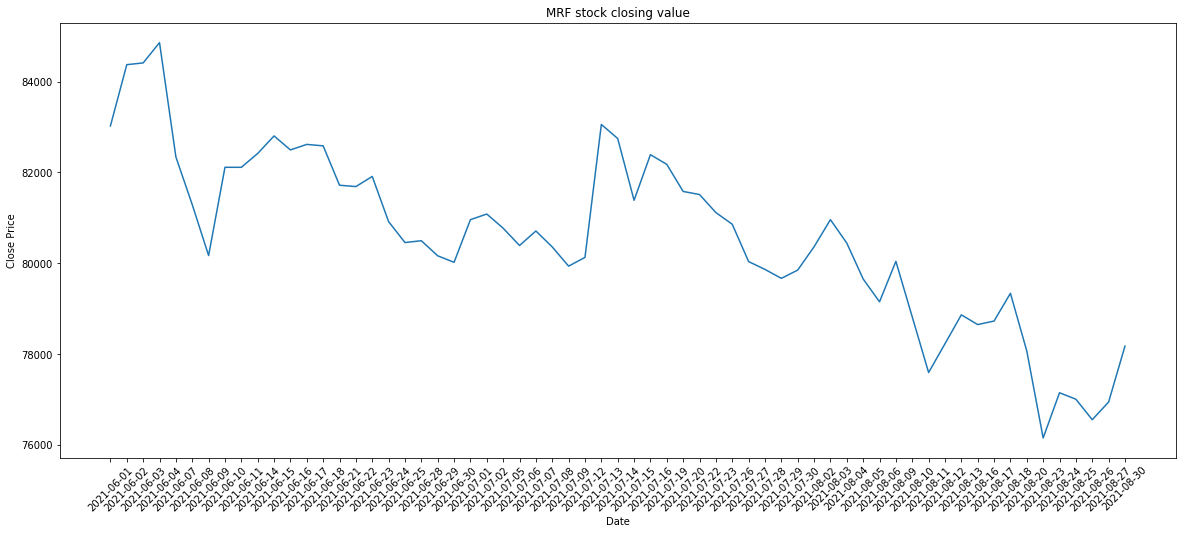

In [ ]:
%matplotlib inline

mrf = df[df.tic =="MRF.NS"]
mrf.set_index('date',inplace=True,drop=False)
mrf = mrf["2021-06-01":"2021-08-30"]
plt.figure(figsize=(20,8))
plt.plot('date','close',data=mrf)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.title("MRF stock closing value")
plt.show()

#### Daily Returns of the stocks

* Apply pct_change() and extract daily returns

* Plot the histogram of daily returns

* Find the stock with maximum daily return

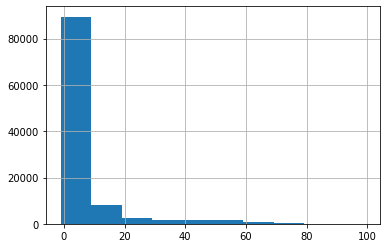

In [ ]:
df1 = df.copy()
df1['Daily Lag'] = df1['close'].shift(1)
df1['Daily Returns'] = (df1['Daily Lag']/df1['close']) -1
df1['Daily Returns'].hist()

In [ ]:
# Maximum Daily return stock
df1[df1['Daily Returns'] == df1['Daily Returns'].max()]

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,Daily Lag,Daily Returns
31242,2009-03-06,33.333332,33.333332,31.4,27.275555,23902,CADILAHC.NS,4,-0.370386,31.641444,27.837514,33.577188,-144.922119,39.242887,29.395523,29.644299,2735.898926,99.305895


### Train & Trade Data Split

In real life trading, the model needs to be updated periodically using rolling windows. Here, we just slice the data once into train and trade set.

In [ ]:
# Train and trade data
train = data_split(df, start = '2009-01-02', end = '2021-01-01')
trade = data_split(df, start = '2021-01-01', end = '2021-09-01')
# Check the length of the two datasets
print(len(train))
print(len(trade))

100504
5576


In [ ]:
train.close.max(), train.close.min()

(80463.6640625, 7.416604042053223)

### Build Environment

* stock_dim: (int) number of unique stocks

* hmax : (int) maximum number of shares to trade

* initial_amount: (int) start money

* transaction_cost_pct : (float) transaction cost percentage per trade

* reward_scaling: (float) scaling factor for reward, good for training

* tech_indicator_list: (list) a list of technical indicator names (modified from config.py)

In [ ]:
# Compute State Space and Action Space
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 34, State Space: 341


In [ ]:
buy_cost_list = [0.001] * stock_dimension
sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

# Initialize an environment class
env_kwargs = {
    "hmax": 50,                                                # max number of share purchases allowed per asset
    "initial_amount": 189628060,                                  # amount of cash initially available
    "buy_cost_pct": buy_cost_list,                                      # cost for buying shares
    "sell_cost_pct": sell_cost_list,                                     # cost for selling shares
    "state_space": state_space,                                 # contains all of the environment’s data to be observed by the agent
    "stock_dim": stock_dimension,
    "num_stock_shares": num_stock_shares,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,                            # contain all of the actions possible for an agent to take in the environment
    "reward_scaling": 1e-4 }                                    # scaling value to multiply reward by at each step

e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### Implement DRL Algorithms

Use Soft Actor-Critic (SAC) for stock trading, it is one of the most recent state-of-art algorithms. SAC is featured by its stability.

* Define the SAC parameters and train the SAC model
* Optimize the parameters to improve the reward

In [ ]:
# Train SAC Model
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100,
    "learning_rate": 0.001,
    "learning_starts": 200,
    "ent_coef": "auto_0.1"
}
model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=30000)

{'batch_size': 128, 'buffer_size': 100, 'learning_rate': 0.001, 'learning_starts': 200, 'ent_coef': 'auto_0.1'}
Using cuda device
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 31         |
|    time_elapsed    | 380        |
|    total_timesteps | 11824      |
| train/             |            |
|    actor_loss      | 2.26e+07   |
|    critic_loss     | 2.9e+09    |
|    ent_coef        | 7.42e+03   |
|    ent_coef_loss   | -3.85e+03  |
|    learning_rate   | 0.001      |
|    n_updates       | 11623      |
|    reward          | -2551.1028 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 31         |
|    time_elapsed    | 756        |
|    total_timesteps | 23648      |
| train/             |            |
|    actor_loss      | 2.3e+12    |
|    critic_loss     | 3.62e+23   |
|    e

### Trading
* Build the Environment for trading
* Use the trained SAC model to trade

In [ ]:
# Trade data
trade.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2021-01-01,15800.000000,15856.299805,15698.000000,15606.412109,22888,ABBOTINDIA.NS,4,37.079085,16364.910448,14937.749220,50.170534,25.483500,1.959178,15493.354525,15514.264209
0,2021-01-01,1617.199951,1632.000000,1615.650024,1613.873291,647892,ACC.NS,4,-9.297671,1676.205921,1553.247839,51.721860,-50.304190,8.051946,1640.422221,1624.980046
0,2021-01-01,477.000000,493.250000,477.000000,490.824188,5035248,ADANIENT.NS,4,22.135240,496.379506,428.706440,69.721737,119.165293,1.443532,445.374368,390.680674
0,2021-01-01,249.000000,251.699997,248.149994,244.750854,4011077,AMBUJACEM.NS,4,-0.681007,252.358347,230.547732,54.254256,-15.358582,10.496427,245.290738,240.588246
0,2021-01-01,2405.500000,2430.000000,2395.000000,2413.377686,423934,APOLLOHOSP.NS,4,29.018185,2461.212885,2334.596343,58.366024,47.958441,1.738280,2381.310588,2272.389537


In [ ]:
# Create trading env
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

# Make prediction and get the account value change
df_account_value, df_actions = DRLAgent.DRL_prediction(model = trained_sac, environment = e_trade_gym)

hit end!


In [ ]:
df_account_value.head()

,date,account_value
0,2021-01-01,1.896281e+08
1,2021-01-04,1.897525e+08
2,2021-01-05,1.898892e+08
3,2021-01-06,1.897993e+08
4,2021-01-07,1.895531e+08


### Backtesting Performance

Backtesting plays a key role in evaluating the performance of a trading strategy. Backtesting assesses the viability of a trading strategy by discovering how it would perform on historical data. If backtesting works, traders and analysts may have increased confidence to employ it going forward.Automated backtesting tool is preferred because it reduces the human error.

`FinRL` uses a set of functions to do the backtesting with [Quantopian pyfolio](https://github.com/quantopian/pyfolio) package. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

* Perform backtest on the account values and baseline data

In [ ]:
# BackTestStats
perf_stats_all = backtest_stats(account_value = df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

Annual return         -0.009073
Cumulative returns    -0.005914
Annual volatility      0.194522
Sharpe ratio           0.049542
Calmar ratio          -0.054526
Stability              0.219323
Max drawdown          -0.166401
Omega ratio            1.008604
Sortino ratio          0.070939
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.095181
Daily value at risk   -0.024469
dtype: float64


In [ ]:
# Baseline stats
baseline_df = trade
stats = backtest_stats(baseline_df, value_col_name = 'close')

Annual return            -0.280231
Cumulative returns       -0.999308
Annual volatility      3076.783387
Sharpe ratio              3.405249
Calmar ratio             -0.280262
Stability                 0.001413
Max drawdown             -0.999889
Omega ratio              97.271235
Sortino ratio          1129.469977
Skew                           NaN
Kurtosis                       NaN
Tail ratio              127.775646
Daily value at risk    -346.062030
dtype: float64


In [ ]:
df_account_value.date.min(),df_account_value.date.max()

('2021-01-01', '2021-08-31')

### Plot the Backtest plot with baseline ticker as "^NSEI"

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (163, 8)


Start date,2021-01-01
End date,2021-08-31
Total months,7
,Backtest
Annual return,-0.907%
Cumulative returns,-0.591%
Annual volatility,19.452%
Sharpe ratio,0.05
Calmar ratio,-0.05
Stability,0.22
Max drawdown,-16.64%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.64,2021-02-10,2021-05-14,NaT,NaN
1,4.67,2021-01-20,2021-01-29,2021-02-04,12
2,0.98,2021-01-14,2021-01-18,2021-01-20,5
3,0.89,2021-02-04,2021-02-05,2021-02-09,4
4,0.18,2021-01-05,2021-01-07,2021-01-08,4


Stress Events,mean,min,max
New Normal,0.00%,-4.48%,4.40%


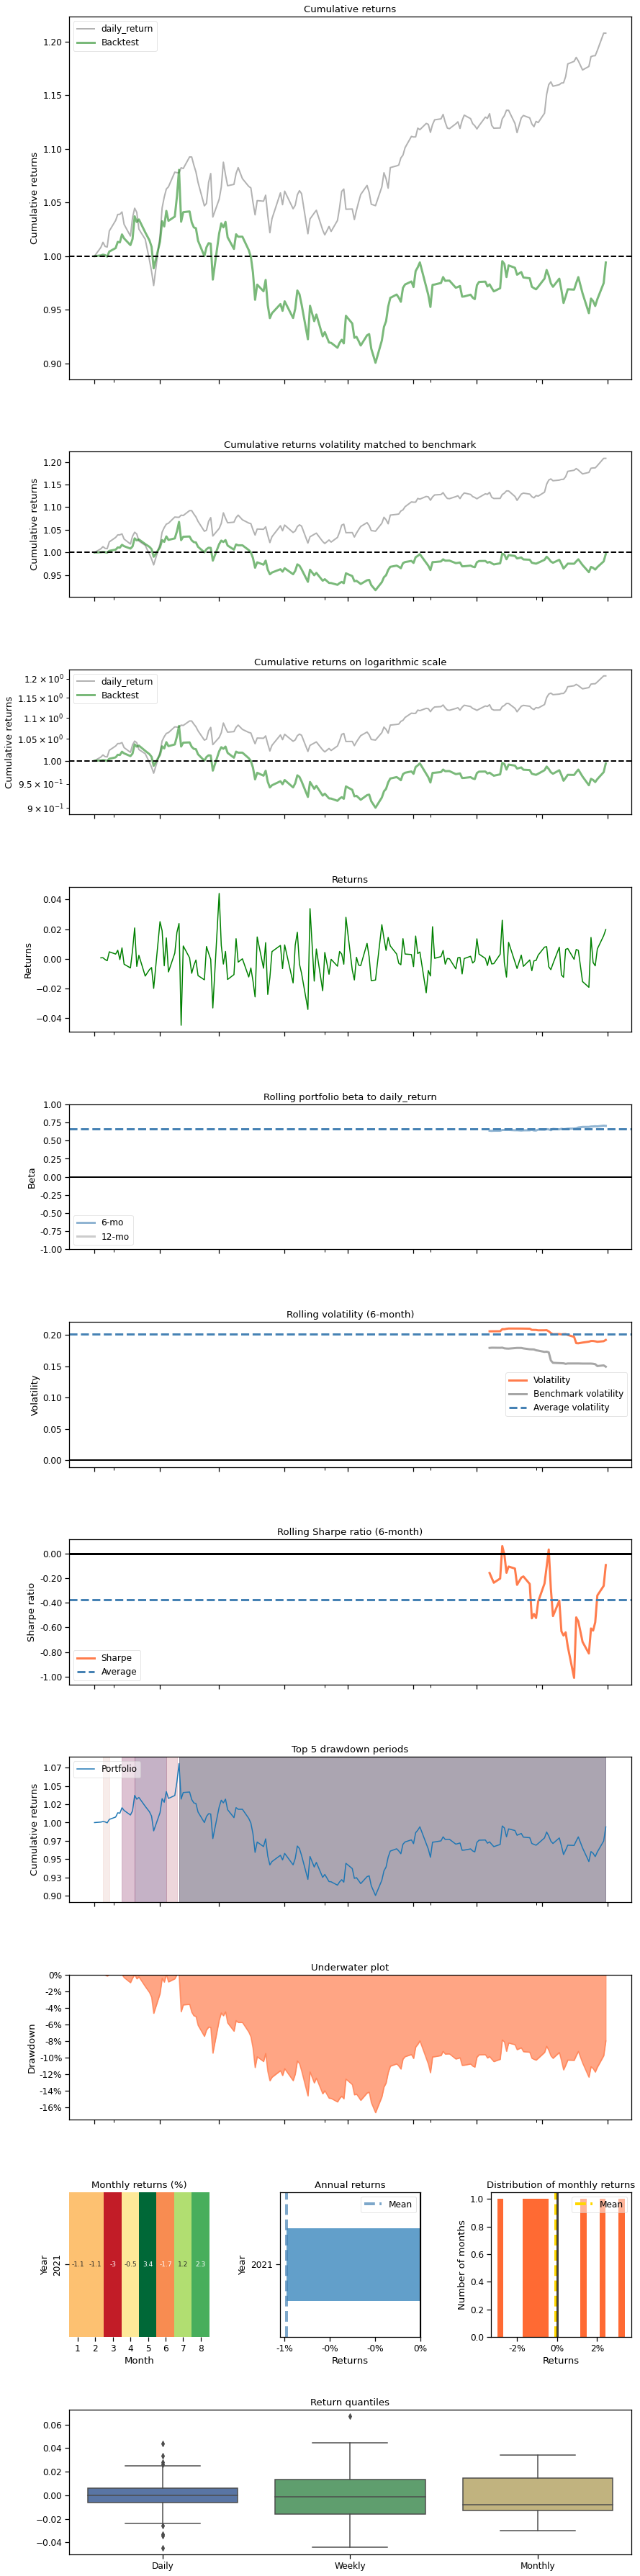

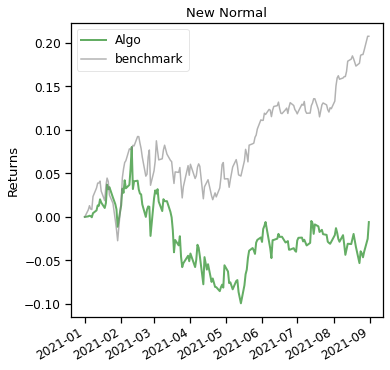

In [ ]:
# BackTestPlot
%matplotlib inline
backtest_plot(account_value = df_account_value,     # pass the account value memory into the backtest functions
              baseline_ticker = '^NSEI',             # select a baseline ticker Dow Jones Index: ^DJI, S&P 500: ^GSPC, NASDAQ 100: ^NDX
              baseline_start = '2021-01-01',
              baseline_end = '2021-08-31')

### DashBoard

Dash is a simple open source library. It is the original low-code framework for rapidly building data apps in Python, R, Julia, and F#. It can bind a user interface to Python code in less than 10 minutes.

Dash apps are rendered in the web browser. Since Dash apps are viewed in the web browser, Dash is inherently cross-platform and mobile ready.

Dash is released under the permissive MIT license. Plotly develops Dash and also offers a platform for writing and deploying Dash apps.

Refer to Dash Documentation [here](https://dash.plotly.com/). Mainly refer to Part 2 (Layout) and Part 3 (Basic callbacks) within the Dash tutorial in the given documentation.

To know more about Dash, refer [here](https://medium.com/plotly/introducing-jupyterdash-811f1f57c02e).



#### Create the dashboard using Dash HTML components

Hint: [Layout](https://dash.plotly.com/layout) , [callbacks](https://dash.plotly.com/basic-callbacks)

* Scatter plot of Stock closing price
  * Create a dropdown for ticker Symbols
  * Create a plot of stock closing price values that changes upon selecting ticker using drop down
* Bar plot of trade off balance resulted from DRL Agent
  * Create two dropdowns for selecting start and end dates
  * Create a bar plot showing account value between start and end date as a result to dropdown change.


In [ ]:
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("Stocks Dashboard using JupyterDash"),
    html.Label([
        "ticker",
        dcc.Dropdown(
            id='ticker-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in set(df.tic)
            ])
    ]),
    dcc.Graph(id='graph1'),
    html.H2("Trade off Balance Given by DRL Agent"),
    html.Label([
        "startDate",
        dcc.Dropdown(
            id='startDate-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in df_account_value.date.values
            ])
    ]),
    html.Label([
        "endDate",
        dcc.Dropdown(
            id='endDate-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in df_account_value.date.values
            ])
    ]),
    dcc.Graph(id='graph2'),
])

# Define callback to update graph
@app.callback(
    Output('graph1', 'figure'),
    [Input("ticker-dropdown", "value")]
)
def update_graph1(ticker):
    ticker_df = df[df.tic == ticker]
    #df_account_value = getResult_from_Agent(required)
    return px.scatter(ticker_df, x='date', y='close')

# Define callback to update graph
@app.callback(
    Output('graph2', 'figure'),
    [Input("startDate-dropdown", "value"),Input("endDate-dropdown", "value")]
)
def update_figure(startDate,endDate):
    required = df_account_value[(df_account_value.date > startDate) & (df_account_value.date < endDate)]
    #df_account_value = getResult_from_Agent(required)
    return px.bar(required, x='date', y='account_value')

In [ ]:
# Run app and display result on external broswer
app.run_server(mode='external')
# app.run_server()

Dash app running on:


<IPython.core.display.Javascript object>

### Report Analysis

* Discuss on the parameters used to increase the reward
* Report the safest stocks to trade without much loss
* Comment on the Dashboard application and user interface


**References:**

http://finrl.org/tutorial/finrl_multiple_stock.html

FinRL Doc: http://finrl.org/tutorial/finrl_single_stock.html

https://www1.nseindia.com/products/content/equities/indices/nifty_50.htm

https://finance.yahoo.com/quote/%5ENSEI/components/

Reference for participants: https://analyticsindiamag.com/stock-market-prediction-using-finrl/

https://medium.com/plotly/introducing-jupyterdash-811f1f57c02e